In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def make_sparse_regression(n = 240 , d = 200 , k = 8 , noise = 1.0 , seed = 7):
    rng = np.random.default_rng(seed)
    X = rng.normal(size = (n , d))
    X = (X - X.mean(axis = 0)) / (X.std(axis = 0) + 1e-12)
    w_true = np.zeros(d)
    idx = rng.choice(d , size = k , replace = False)
    w_true[idx] = rng.normal(0 , 2.0 , size = k)
    y = X @ w_true + rng.normal(0 , noise , size = n)
    return X , y , w_true , idx

def split_60_20_20(X , y , seed = 7):
    rng = np.random.default_rng(seed)
    n = len(y)
    p = rng.permutation(n)
    n_tr , n_va = int(0.6 * n) , int(0.2 * n)
    tr , va , te = p[ : n_tr] , p[n_tr : n_tr + n_va] , p[n_tr + n_va : ]
    return (X[tr] , y[tr]) , (X[va] , y[va]) , (X[te] , y[te])

In [14]:
def mse(X , y , w):
    r = X @ w - y
    return float(np.mean(r * r))

def loss_half_mse(X , y , w):
    r = X @ w - y
    return 0.5 * float(np.mean(r * r))

def grad_half_mse(X , y , w):
    n = X.shape[0]
    return (X.T @ (X @ w - y)) / n

def soft_threshold(z , lam):
    if z > lam: return z - lam
    if z < -lam: return z + lam
    return 0.0

In [15]:
#=================================================================
# Coordinate Descent for Lasso: (1/2n)||Xw-y||^2 + alpha*||w||_1
#=================================================================
def lasso_cd(X , y , alpha = 0.05 , iters = 60):
    n , d = X.shape
    w = np.zeros(d)
    col_norm = (X ** 2).mean(axis = 0) + 1e-12

    obj = []
    for _ in range(iters):
        for j in range(d):
            r = y - (X @ w) + X[ : , j] * w[j]
            rho = (X[ : , j] @ r) / n
            w[j] = soft_threshold(rho , alpha) / col_norm[j]
        obj.append(loss_half_mse(X , y , w) + alpha * np.sum(np.abs(w)))
    return w , np.array(obj)

In [16]:
def gd_train(Xtr , ytr , Xva , yva , lr_fn , iters = 250 , blowup = 1e8):
    w = np.zeros(Xtr.shape[1])
    tr_hist , va_hist , lr_hist = [] , [] , []

    for t in range(1 , iters + 1):
        lr = lr_fn(t)
        w -= lr * grad_half_mse(Xtr , ytr , w)

        lt = loss_half_mse(Xtr , ytr , w)
        lv = loss_half_mse(Xva , yva , w)

        tr_hist.append(lt)
        va_hist.append(lv)
        lr_hist.append(lr)
        if (not np.isfinite(lt)) or (lt > blowup) or (not np.isfinite(lv)) or (lv > blowup):
            break

    return w , np.array(tr_hist) , np.array(va_hist) , np.array(lr_hist)

Method        |train MSE | val MSE | test MSE
------------------------------------------------------------
Lasso + CD    |    0.435 |   1.299 |    1.551
GD (fixed)    | 238340210.714 | 44151081.942 | 41088091.673
GD (sched)    |    0.002 |   9.178 |   10.485


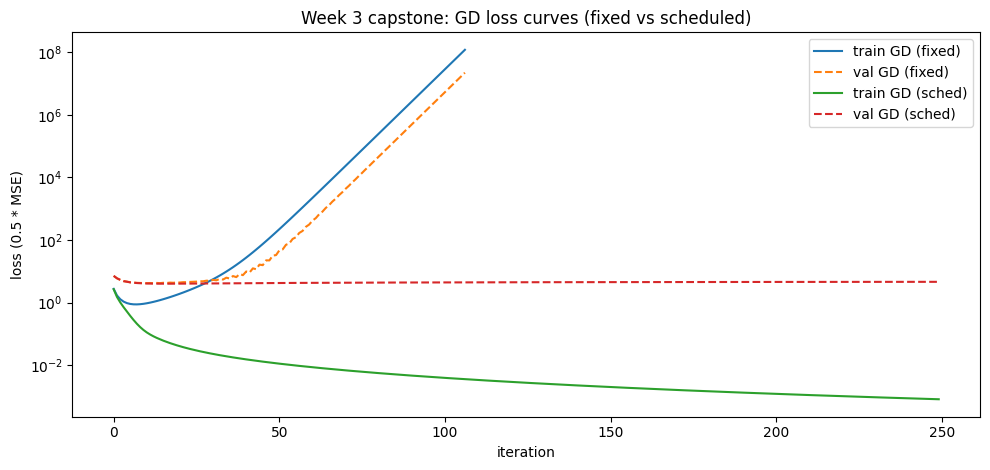

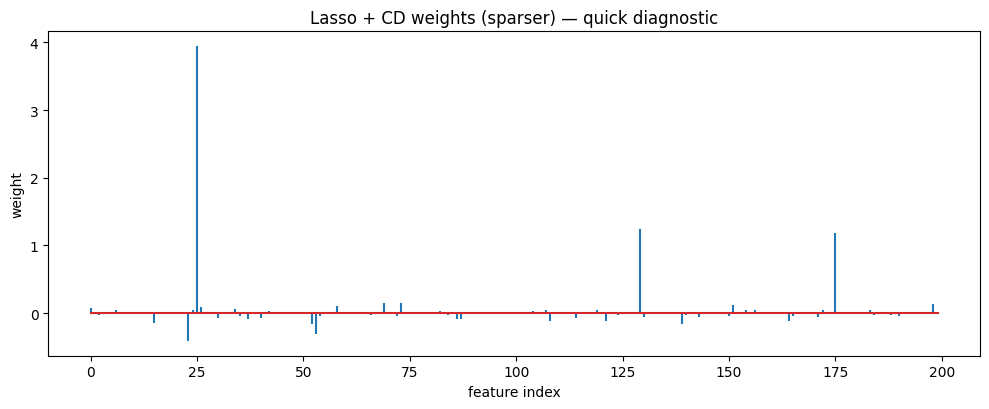

In [17]:
def train_and_compare(seed = 42):
    X , y , w_true , support = make_sparse_regression(seed = seed)
    (Xtr , ytr) , (Xva , yva) , (Xte , yte) = split_60_20_20(X , y , seed = seed)

    w_cd , obj_cd = lasso_cd(Xtr , ytr , alpha = 0.05 , iters = 60)
    lr_good = 4.67e-01
    w_gd , tr_gd , va_gd , lr_gd = gd_train(Xtr , ytr , Xva , yva , lr_fn = lambda t: lr_good)
    w_sched , tr_s , va_s , lr_s = gd_train(Xtr , ytr , Xva , yva , lr_fn = lambda t: lr_good / (1.0 + 0.02 * t))

    rows = [
        ("Lasso + CD" , mse(Xtr , ytr , w_cd) , mse(Xva , yva , w_cd) , mse(Xte , yte , w_cd)) ,
        ("GD (fixed)" , mse(Xtr , ytr , w_gd) , mse(Xva , yva , w_gd) , mse(Xte , yte , w_gd)) ,
        ("GD (sched)" , mse(Xtr , ytr , w_sched) , mse(Xva , yva , w_sched) , mse(Xte , yte , w_sched)) ,
    ]

    print("Method        |train MSE | val MSE | test MSE")
    print("-" * 60)
    for name , trm , vam , tem in rows:
        print(f"{name:<13} | {trm:8.3f} | {vam:7.3f} | {tem:8.3f}")

    plt.figure(figsize = (10 , 4.8))
    plt.plot(tr_gd , label = "train GD (fixed)")
    plt.plot(va_gd , "--" , label = "val GD (fixed)")
    plt.plot(tr_s , label = "train GD (sched)")
    plt.plot(va_s , "--" , label = "val GD (sched)")
    plt.yscale("log")
    plt.title("Week 3 capstone: GD loss curves (fixed vs scheduled)")
    plt.xlabel("iteration")
    plt.ylabel("loss (0.5 * MSE)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10 , 4.2))
    plt.stem(w_cd , label = "Lasso + CD" , markerfmt = " ")
    plt.title("Lasso + CD weights (sparser) — quick diagnostic")
    plt.xlabel("feature index")
    plt.ylabel("weight")
    plt.tight_layout()
    plt.show()

train_and_compare(seed = 42)